### Config

In [1]:
import os

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = str(0)
import sys
import torch

PROJ_ROOT = os.path.dirname(os.getcwd())
sys.path.append(PROJ_ROOT)

TEST_NAME = "og-lion"
OBJ_NAME = "lion-void"
UPSCALE = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

DATASPACE_DIR = os.path.join(PROJ_ROOT, "dataspace")
REFERENCES_DIR = os.path.join(PROJ_ROOT, "data", "objects", OBJ_NAME)
VIDEO_DIRECTORY_PATH = os.path.abspath(
    os.path.join(PROJ_ROOT, "data", "inputs", TEST_NAME)
)
VIDEO_IMG_DIRECTORY = os.path.join(VIDEO_DIRECTORY_PATH, "img")
MASK_PATH = os.path.join(VIDEO_DIRECTORY_PATH, "masks", "0.png")
PIXELTRACKER_RESULTS_DIR = os.path.join(VIDEO_DIRECTORY_PATH, "tracks")
PIXELTRACKER_RESULTS_PATH = os.path.join(PIXELTRACKER_RESULTS_DIR, "tracks.npy")
PIXELTRACKER_3D_RESULTS_PATH = os.path.join(PIXELTRACKER_RESULTS_DIR, "3d.npy")
QUERY_RESULTS_PATH = os.path.join(VIDEO_DIRECTORY_PATH, "queries.npy")

cuda


In [2]:
# from dataset.inference_datasets import YCBInEOAT_Dataset
# from posingpixels.alignment import PixelToGaussianAligner
import numpy as np
import mediapy
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import mediapy
from tqdm import tqdm
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
from torchvision import transforms
from PIL import Image
import os
from typing import List, Iterator, Tuple
import numpy as np
from cotracker.predictor import CoTrackerPredictor, CoTrackerOnlinePredictor


# from posingpixels.utils.gs_pose import render_gaussian_model
# from posingpixels.utils.gs_pose import (
#     create_or_load_gaussian_splat_from_images,
# )
# from posingpixels.visualization import get_gaussian_splat_pointcloud, plot_pointclouds
# from posingpixels.utils.gs_pose import perform_pose_estimation

# from dataset.demo_dataset import OnePoseCap_Dataset
# from posingpixels.visualization import get_points_pointcloud
# from posingpixels.optimization import (
#     MultiTimestampRenderPoseModel6D,
#     render_train_model,
# )
# from posingpixels.visualization import plot_per_point_losses
# from posingpixels.visualization import (
#     overlay_bounding_box_on_video,
#     overlay_gaussian_splat_on_video,
#     plot_points_on_video,
#     video_to_grayscale,
# )

# from posingpixels.alignment import get_safe_query_points


In [3]:
from posingpixels.datasets import ImageBatchIterator

def get_offline_cotracker_predictions(video_img_directory, grid_size = 10, mask_path = None, downcast = False, device = torch.device("cuda")):
    len_video = len(os.listdir(video_img_directory))
    if mask_path:
        mask = torch.tensor(np.array(Image.open(MASK_PATH))).to(device)[None, None]
    else:
        mask = None
    video = next(ImageBatchIterator(video_img_directory, batch_size=len_video, device=device))
    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=downcast):
        cotracker_offline = CoTrackerPredictor().to(device)
        pred_tracks, pred_visibility = cotracker_offline(video, grid_size = grid_size, segm_mask=mask) # B T N 2,  B T N 1
    return pred_tracks, pred_visibility

def get_online_cotracker_predictions(video_img_directory, grid_size = 10, step = 8, downcast = False, device = torch.device("cuda")):
    batch_iterator = ImageBatchIterator(video_img_directory, batch_size=step * 2, overlap=step, device=device)
    is_first_step = True
    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=downcast):
        cotracker_online = CoTrackerOnlinePredictor(window_len=step*2).to(device)
        for batch in tqdm(batch_iterator, desc="Processing batches"):
            pred_tracks, pred_visibility = cotracker_online(video_chunk=batch, is_first_step=is_first_step, grid_size=grid_size)
            is_first_step = False
    return pred_tracks, pred_visibility

# pred_tracks, pred_visibility = get_offline_cotracker_predictions(VIDEO_IMG_DIRECTORY, grid_size=3, mask_path = MASK_PATH, downcast = True)
pred_tracks, pred_visibility = get_online_cotracker_predictions(VIDEO_IMG_DIRECTORY, grid_size=20, downcast = False)

# len_video = len(os.listdir(VIDEO_IMG_DIRECTORY))
# W, H = Image.open(os.path.join(VIDEO_IMG_DIRECTORY, "00000.jpg")).size
# mask = torch.tensor(np.array(Image.open(MASK_PATH))).to(device)[None, None]
# grid_size = 12
# video = next(ImageBatchIterator(VIDEO_IMG_DIRECTORY, batch_size=len_video, image_size=(H, W), device=device))
# with torch.autocast(device_type="cuda", dtype=torch.float16):
#     cotracker_offline = torch.hub.load("facebookresearch/co-tracker", "cotracker3_offline").to(device)
#     pred_tracks, pred_visibility = cotracker_offline(video, segm_mask=mask) # B T N 2,  B T N 1

KeyboardInterrupt: 

In [ ]:
from posingpixels.visualization import plot_points_on_video
from cotracker.utils.visualizer import Visualizer
video = torch.tensor(mediapy.read_video(
        os.path.join(VIDEO_DIRECTORY_PATH, "Frames.m4v")
    ), dtype=torch.int8, device=device).permute(0, 3, 1, 2).unsqueeze(0)
print(pred_tracks.shape)
print(pred_visibility.shape)
print(video.shape)
vis = Visualizer(save_dir=PIXELTRACKER_RESULTS_DIR, pad_value=0, linewidth=3)
vis.visualize(video, pred_tracks, pred_visibility)

torch.Size([1, 1095, 400, 2])
torch.Size([1, 1095, 400])
torch.Size([1, 1095, 3, 720, 1280])
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/og-lion/tracks/video.mp4


tensor([[[[[239, 239, 215,  ..., 172, 159, 150],
           [245, 239, 215,  ..., 157, 148, 143],
           [233, 225, 212,  ..., 143, 140, 142],
           ...,
           [  9,  16,  21,  ..., 173, 167, 163],
           [  1,   8,  15,  ..., 172, 161, 155],
           [  3,   8,  13,  ..., 166, 153, 146]],

          [[236, 236, 212,  ..., 166, 153, 144],
           [242, 236, 212,  ..., 151, 142, 137],
           [230, 222, 209,  ..., 137, 134, 136],
           ...,
           [ 36,  43,  48,  ..., 167, 161, 157],
           [ 29,  36,  43,  ..., 166, 155, 149],
           [ 31,  36,  41,  ..., 160, 147, 140]],

          [[229, 229, 205,  ..., 152, 139, 130],
           [235, 229, 205,  ..., 137, 128, 123],
           [223, 215, 202,  ..., 123, 120, 122],
           ...,
           [ 67,  74,  79,  ..., 155, 149, 145],
           [ 63,  70,  77,  ..., 154, 143, 137],
           [ 65,  70,  75,  ..., 148, 135, 128]]],


         [[[239, 239, 215,  ..., 172, 159, 150],
           [2

In [ ]:
from dataset.inference_datasets import YCBInEOAT_Dataset
from posingpixels.alignment import PixelToGaussianAligner
import numpy as np
import matplotlib.pyplot as plt
from posingpixels.utils.gs_pose import render_gaussian_model
from posingpixels.utils.gs_pose import (
    create_or_load_gaussian_splat_from_images,
    load_model_net,
    load_test_data,
)
from posingpixels.visualization import get_gaussian_splat_pointcloud, plot_pointclouds
from posingpixels.utils.gs_pose import perform_pose_estimation
from dataset.demo_dataset import OnePoseCap_Dataset
from posingpixels.visualization import get_points_pointcloud
from posingpixels.optimization import (
    MultiTimestampRenderPoseModel6D,
    render_train_model,
)
from posingpixels.visualization import plot_per_point_losses
import mediapy
from posingpixels.visualization import (
    overlay_bounding_box_on_video,
    overlay_gaussian_splat_on_video,
    plot_points_on_video,
    video_to_grayscale,
)

from posingpixels.alignment import get_safe_query_points



/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [ ]:
# Load GS-Pose model, Gaussian object and video data
video_directory = f"{PROJ_ROOT}/data/inputs/{TEST_NAME}"
object_directory = f"{PROJ_ROOT}/data/objects/{OBJ_NAME}"

object_video_directory = f"{object_directory}/{OBJ_NAME}-annotate"
object_database_directory = f"{object_directory}/{OBJ_NAME}-database"

dataset = OnePoseCap_Dataset(
    obj_data_dir=object_video_directory,
    obj_database_dir=object_database_directory,
    use_binarized_mask=False,
)
reference_database = create_or_load_gaussian_splat_from_images(
    object_database_directory,
    OBJ_NAME,
    None,
    obj_refer_dataset=dataset,
)
gaussian_object = reference_database["obj_gaussians"]
video, camKs = load_test_data(VIDEO_DIRECTORY_PATH)
H, W = video[0].shape[:2]

object_pointcloud = get_gaussian_splat_pointcloud(gaussian_object)
plot_pointclouds({OBJ_NAME.capitalize(): object_pointcloud}, "Gaussian Object")

Load database from  /home/joao/Documents/repositories/GSPose/data/objects/lion-void/lion-void-database/reference_database.pkl
load 3D-OGS model from  /home/joao/Documents/repositories/GSPose/data/objects/lion-void/lion-void-database/3DGO_model.ply


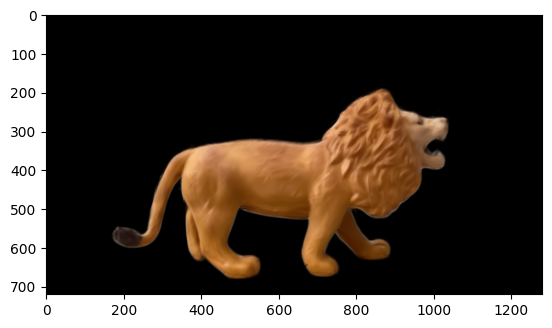

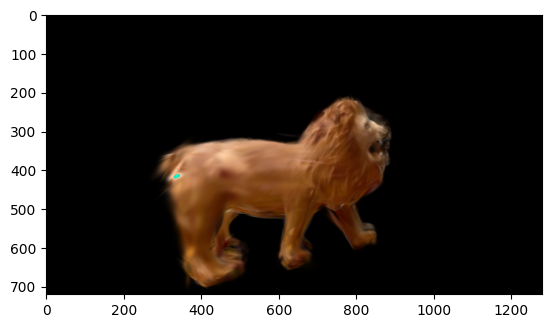

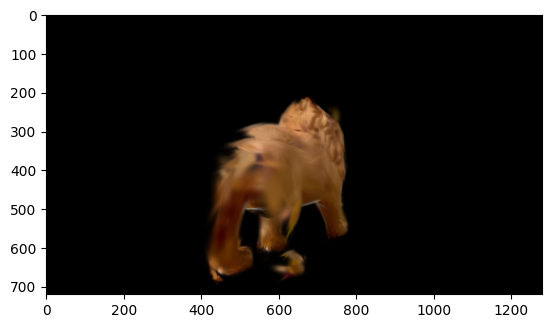

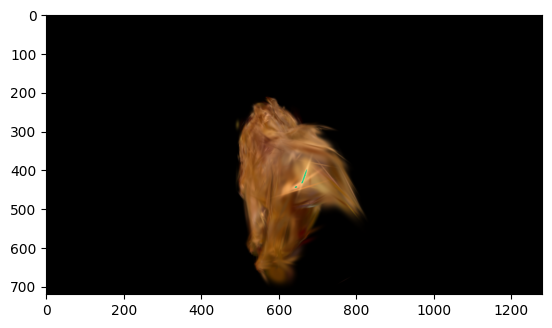

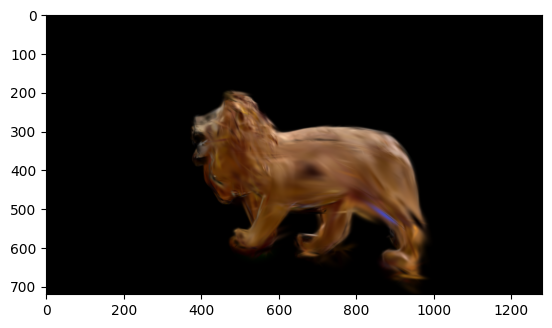

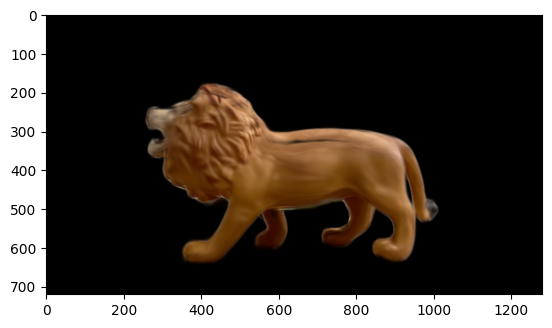

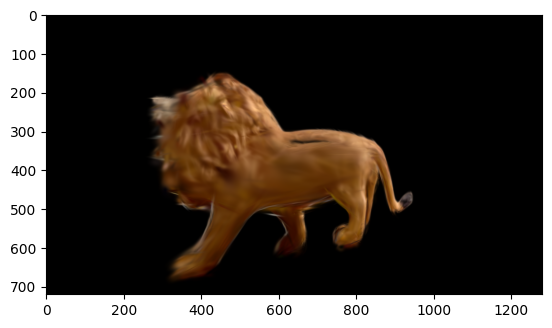

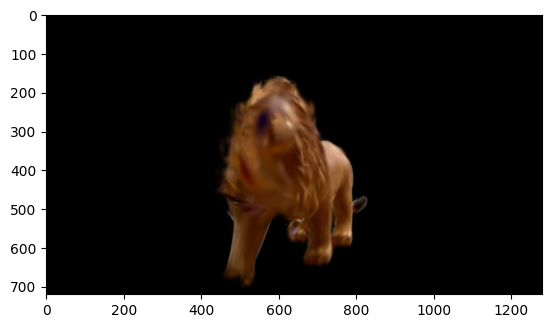

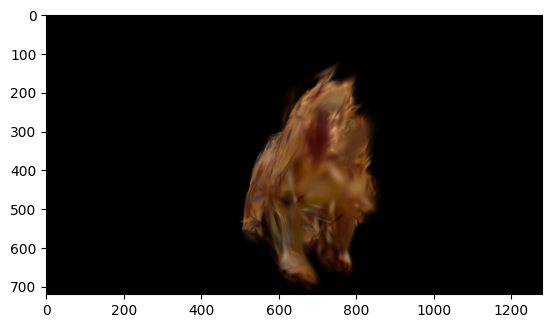

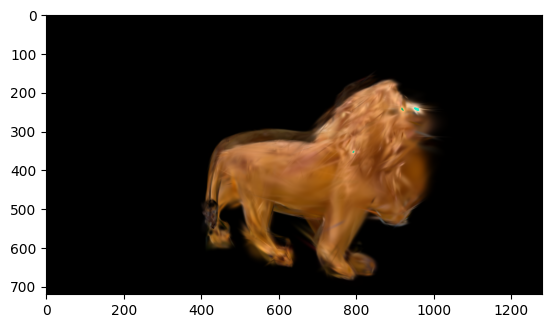

In [ ]:
from posingpixels.utils.gs_pose import render_gaussian_model_with_info


def generate_rotation_matrices_y(S):
    # Initialize an empty list to store rotation matrices
    rotation_matrices = []
    
    # Define the angle increment
    delta_theta = 2 * np.pi / S
    
    # Loop through S steps to generate each rotation matrix
    for s in range(S):
        # Calculate the current angle
        theta = s * delta_theta
        
        # Define the rotation matrix around the x-axis
        R_x = np.array([
            [np.cos(theta), 0, np.sin(theta)],
            [0, 1, 0],
            [np.sin(theta), 0, np.cos(theta)]
        ])
        
        # Append the matrix to the list
        rotation_matrices.append(R_x)
    
    return rotation_matrices

rotation_matrices = generate_rotation_matrices_y(10)

R = np.eye(3)
# Flip on y-axis
R[1, 1] = -1
t = np.array([0, 0, dataset.bbox3d_diameter])
for rotation_matrice in rotation_matrices:
    render = render_gaussian_model_with_info(gaussian_object, camKs[0], H, W, R @ rotation_matrice, t)
    plt.imshow(render['image'])
    plt.show()

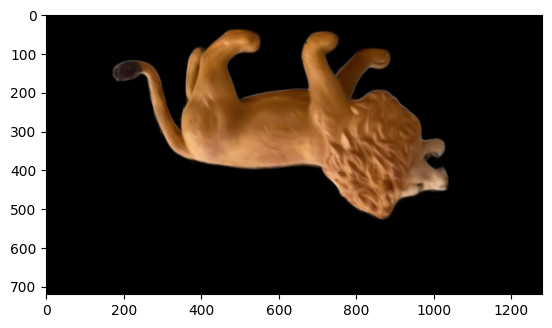

In [ ]:
R = np.eye(3)
# Rotate 90 degrees on x-axis

T = np.array([0.0, 0.0, dataset.bbox3d_diameter])

render = render_gaussian_model_with_info(gaussian_object, camKs[0], H, W, R, T)
plt.imshow(render['image'])
plt.show()